# [IAPR 2019:][iapr2019] Special project

**Group members:**
    1- Gianni GIUSTO,
    2- Raphaël REIS NUNES,
    3- Christelle SCHNEUWLY

**Due date:** 30.05.2019

[iapr2019]: https://github.com/LTS5/iapr-2019


## Description
Please find the description of this special project via [this link].

[this link]: https://github.com/LTS5/iapr-2019/blob/master/project/special_project_description.pdf

## Part 1: Finding varroas by segmentation
Add your implementation for ''**detect_by_segmentation**'' function. Please make sure the input and output follows the mentioned format.

In [3]:
# Some imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import skimage.io
import matplotlib.patches as mpatches
from skimage import measure

from skimage.morphology import binary_opening, remove_small_objects

from skimage.color import rgb2gray, rgb2grey
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
from skimage.measure import find_contours

from skimage.io import imsave

import matplotlib.font_manager
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score
from sklearn.naive_bayes import GaussianNB

In [4]:
import tarfile
import os

# extract the .tar.gz archive
data_folder = 'data'
data_filename = 'project-data'
tar_path = os.path.join(data_folder, data_filename + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_folder)

#### Parsing & Ploting

In [5]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [6]:
# Extract image and annotations paths
train_im_path = os.path.join(data_folder, data_filename, 'images', 'train')
test_im_path = os.path.join(data_folder, data_filename, 'images', 'test')
validation_im_path = os.path.join(data_folder, data_filename, 'images', 'validation')

train_anno_path = os.path.join(data_folder, data_filename, 'annotations', 'train')
test_anno_path = os.path.join(data_folder, data_filename, 'annotations', 'test')
validation_anno_path = os.path.join(data_folder, data_filename, 'annotations', 'validation')

In [7]:
annotations_xmls = [parse_file(os.path.join(test_anno_path, filename)) for filename in os.listdir(test_anno_path)]
#Sanity check
print(len(annotations_xmls))
filenames  = [filename for filename in os.listdir(test_im_path)]
ic = [skimage.io.imread(os.path.join(test_im_path, filename)) for filename in os.listdir(test_im_path)]
#Sanity check
print(len(ic))

50
50


#### Segmentation


In [8]:
def detect_by_segmentation(image):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''

    #Remove background
    value_img = rgb2gray(image)
    thresh = threshold_otsu(value_img)
    
    #Distinguish between two type of objects 
    thresh2 = threshold_otsu(value_img[value_img < thresh])
    binary = (value_img < thresh2)
    
    #Label image
    label_image = label(binary)
    proprieties = regionprops(label_image)
    
    #Parameters for the varroas size
    min_area = 500
    max_area = 750
    
    #Keep the label in the correct size range and with an approximatively squared bbox
    large_label = [prop for prop in proprieties if ((prop.area > min_area) and (prop.area < max_area)) and 
                   (max(prop.bbox[3]-prop.bbox[1],prop.bbox[2]-prop.bbox[0])/min(prop.bbox[3]-prop.bbox[1],prop.bbox[2]-prop.bbox[0])<2)]
    
    output = []
    def mapping_fun(prop):
        ''' For each property received, it returns centroid position and width and height of the bbox'''
        y_i, x_i = prop.centroid
        min_row, min_col, max_row, max_col = prop.bbox
        return [x_i, y_i, max_row-min_row, max_col-min_col]
    
    for prop in large_label:
        output.append(mapping_fun(prop))
    
    return output

In [9]:
# Load images
data_path = test_im_path
im_names = []
for r, d, f in os.walk(data_path):
    for file in f:
        if '.jpg' in file:
            im_names.append(file)

im_names = [im[:-4] for im in im_names]
#Let's remove '5a0de18fa07d56baef59b1f8_32.00px_19' since it's a uniform color image and
#that make our algorithm fail.
im_names.remove('5a0de18fa07d56baef59b1f8_32.00px_19')

filenames = [os.path.join(data_path, name) + '.jpg' for name in im_names]
ic = skimage.io.imread_collection(filenames)
print('Number of images: ', len(ic))

Number of images:  49


Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [10]:
flabels = []
uniform_image = []
for index, im in enumerate(ic) :
    if (im.min() != im.max()):
        detections = detect_by_segmentation(im)
        flabels.append(detections)
    else: uniform_image.append(index)

#### Precison, Recall and F1-score

In [13]:
from collections import namedtuple
def overlap(rect1, rect2):  
    '''Computes the overlapping area of two rectangle'''
    dx = min(rect1.xmax, rect2.xmax) - max(rect1.xmin, rect2.xmin)
    dy = min(rect1.ymax, rect2.ymax) - max(rect1.ymin, rect2.ymin)
    if (dx>=0) and (dy>=0):
        return dx*dy
    else: return 0

In [14]:
print(len(annotations_xmls))
print(len(flabels))

50
49


In [15]:
Rectangle = namedtuple('Rectangle', 'xmin, ymin, xmax, ymax')
IoU = []
zero_inter = []
for index, (imlabels,annotations) in enumerate(zip(flabels,annotations_xmls)):
    imIoU = []
    for imlabel in imlabels:
        inter_iou =[]
        
        for anno in annotations:
            grd_t = Rectangle(anno['bbox'][0], anno['bbox'][1], anno['bbox'][2]+anno['bbox'][0], anno['bbox'][3]+anno['bbox'][1])
            f_box = Rectangle(imlabel[0]-imlabel[2]/2, imlabel[1]-imlabel[3]/2, imlabel[0]+imlabel[2]/2, imlabel[1]+imlabel[3]/2)
            overlap_a = overlap(grd_t,f_box)
            # if(overlap_a != 0): print(overlap_a); print("***********")
            grd_t_a = anno['bbox'][2]*anno['bbox'][3]
            f_box_a = (imlabel[2])*(imlabel[3])
            inter_iou.append(overlap_a/(grd_t_a+f_box_a-overlap_a))
            
        if inter_iou:
            imIoU.append(max(inter_iou))
        else : zero_inter.append(index)
    IoU.append(imIoU)

In [16]:
def Precision_Recall_F1(IoU,ground_truth,number_image,T):
    '''Computes the required score for a given T value '''
    Precisions = []
    Recalls = []
    F1_scores =[]
    for imIoU,n in zip(IoU,range(number_image)):
        annotation = ground_truth[n]
        tp = [score for score in imIoU if(score >= T)]
        if (tp != 0) :
            #𝑝𝑟𝑒𝑐𝑖𝑠𝑖𝑜𝑛=𝑡𝑝/𝑡𝑝+𝑓𝑝 
            if(len(imIoU) != 0):
                Precision = len(tp)/(len(imIoU)) # tp+fp is every positive so every label that we selected
            else:
                Precision = 0
                
            #recall=𝑡𝑝/𝑡𝑝+𝑓𝑛
            if(len(annotations_xmls[n]) != 0):
                Recall = len(tp)/len(annotations_xmls[n]) # #fn = #grd truth - #tp so fn+tp = gt -tp + tp = gt
            else:
                Recall = 0
            #𝐹1=2⋅𝑝𝑟𝑒𝑐𝑖𝑠𝑖𝑜𝑛⋅𝑟𝑒𝑐𝑎𝑙𝑙/𝑝𝑟𝑒𝑐𝑖𝑠𝑖𝑜𝑛+𝑟𝑒𝑐𝑎𝑙𝑙
            if ((Precision + Recall) != 0):
                F1_score = (2 * Precision * Recall)/(Precision + Recall)
            else : 
                 F1_score = 0.0
            Precisions.append(Precision)
            Recalls.append(Recall)
            F1_scores.append(F1_score)
        else :
            Precisions.append(0.0)
            Recalls.append(0.0)
            F1_scores.append(0.0)
    return (Precisions,Recalls,F1_scores)

In [17]:
#Threshold = 0.3
Precisions_05,Recalls_05,F1_scores_05 =Precision_Recall_F1(IoU,annotations_xmls,49,0.3)

print("For a T value of 0.3:")
print("")
for precision,recall,score,im in zip(Precisions_05,Recalls_05,F1_scores_05,im_names):
    print("   Image %s: Precision: %g, Recall:  %r, F1_score: %s." % (im,precision,recall,score))
print("")

For a T value of 0.3:

   Image 58e7c5e3579e52085efb48f4_32.00px_2: Precision: 0, Recall:  0, F1_score: 0.0.
   Image 58e7db24579e520d2470641c_32.00px_4: Precision: 0, Recall:  0.0, F1_score: 0.0.
   Image 58ea4f69579e520dd055b3db_32.00px_6: Precision: 0.333333, Recall:  1.0, F1_score: 0.5.
   Image 59023fbd579e52581ddede9f_32.00px_20: Precision: 0, Recall:  0.0, F1_score: 0.0.
   Image 5903312b579e52581ddedea8_32.00px_11: Precision: 0, Recall:  0.0, F1_score: 0.0.
   Image 5903312b579e52581ddedea8_32.00px_4: Precision: 0, Recall:  0, F1_score: 0.0.
   Image 59855d29579e529fdea8af13_32.00px_10: Precision: 0, Recall:  0.0, F1_score: 0.0.
   Image 59919820579e52a0e6c05e46_32.00px_2: Precision: 0, Recall:  0.0, F1_score: 0.0.
   Image 5991982d579e52a0e6c05e47_32.00px_4: Precision: 1, Recall:  0.08695652173913043, F1_score: 0.16.
   Image 599a969f579e52a0e6c05e4f_32.00px_1: Precision: 0.15, Recall:  0.42857142857142855, F1_score: 0.2222222222222222.
   Image 599a969f579e52a0e6c05e4f_32.00p

 #### Conclusion
 
We can see that the precision, recall and F1-score of a lot of the images is 0. This means either there is no varroa or that the segmentation alone on whole images are not good enough to detect varroas from the images. Indeed these images are actually full of non background objects that are not varroas. Segmentation only is not able to distinguish between these small non-varroa objects and true varroas. So that we would need a classification method that would be able to distinguish between the positive true varroas and the rest of the objects obtained with the segmentation. 

## Part 2: Implement your first detector

Write your function(s) for the second part. Feel free to change the name of the function and add your additional functions, but please make sure their input and output follows the mentioned format.

#### Pre-processing and segmentation

As the main goal of this object detection method was to use sliding windows to analyse small areas of a full image separetedly, first we define the sliding window function that can take as an input the full image, a step size and a window size. 

The interest of sliding windows is to have areas small enough to ideally only detect one object at a time and then be able to classify this object as a varroa or not. The sliding window approach also has the advantage to actually process smaller and threfors more uniform images meaning that the thresholding and image preprocessing parts can  be solved locally and specific to the small region.

In [18]:
def sliding_window(image, stepSize, windowSize):
    '''
        Calculates the pixels in sliding window across an image.
        Input:  Image to analyze using the slinding windows 
                Size step to shift the sliding windows 
                Size for the sliding window as a tuple 
    '''
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [19]:
def preprocess(img, show=False, threshold=0.65):
    '''
        Preprocessing of an image in imput by binarizing it using an Otsu threshold and 
        removing small objects. 
        Input:  Image to binarize.
                show = False, turn to True to plot the resulting binary images
                threshold = 0.65, theshold used for empty images
        Output: Cleaned binary image 
    '''
    EMPTY_IMAGE_THRESHOLD = threshold
    if(show):
        plt.subplot(1, 3, 1)
        plt.imshow(img)
    if (img.min() != img.max()):
        thresh = threshold_otsu(img)
        #print(thresh)
        if(thresh > EMPTY_IMAGE_THRESHOLD): 
            black_img = np.zeros_like(img)
            if(show):
                plt.subplot(1, 3, 2)
                plt.imshow(black_img)
                plt.show()
            return black_img
        else:
            binary = (img < thresh)
        
            if(show):
                plt.subplot(1, 3, 2)
                plt.imshow(binary)
        
            cleaned_binary = remove_small_objects(binary, 300).astype(int)
    
            if(show):
                plt.subplot(1, 3, 3)
                plt.imshow(cleaned_binary)
                plt.show()
            
            return cleaned_binary

at position (0,0)


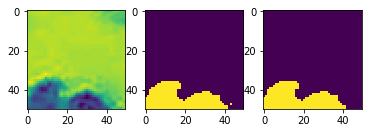

In [20]:
img = rgb2gray(ic[10])
(winW, winH) = (50, 50)
generator = sliding_window(img, stepSize=50, windowSize=(winW, winH))

(x, y, image) = next(generator)
print("at position ({},{})".format(x, y))

bin_im = preprocess(image, True)

#### Feature extraction

First let's define some functions to extract our some features from the binary images. We will make some trials with Fourier descriptors and also the area, perimeter, compacity, eigenvalues ratio, solidity and elongation of an object. 

In [21]:
# First descriptor with fourier
def get_fourier_descriptors(regionproplst):
    '''
        Get amplitude of the first four Fourier descriptor of an image 
        Input : Region poperties for all the binary windows in the full image
        Output : Amplitude of the first four Fourier descriptors
    '''
    
    fourier_descriptors = []
    contourlst = [max(measure.find_contours(region.image, level = 0.5, fully_connected='low', positive_orientation='low'), key = len) for region in regionproplst]
    # re-sample the contours obtained in the segmentation step
    min_contour = min([len(contour) for contour in contourlst])
    sampled_contours = []
    for contour in contourlst:
        fs = min_contour/len(contour)
        idx = np.arange(0, len(contour)-1, 1/fs).astype('int')
        if len(contour) == min_contour:
            sc = contour
        else: 
            sc = [contour[i] for i in idx]
        sampled_contours.append(sc)
    # print(len(sampled_contours[0]))
    # convert our x and y coordinates in complex values as uk = xk +i*yk
    for contour in sampled_contours:
        complex_contour = []
        for i in range(0,len(contour)):
            u = complex(contour[i][1], contour[i][0])
            complex_contour.append(u)
        # calculate the fast Fourier transform of these and normalize them    
        fft = np.fft.fft(complex_contour)
        fft = fft[0:5]
        fft[0]= 0 
        fft = [a / abs(fft[1]) for a in fft] 
        nfft =[np.abs(a)*np.cos(np.angle(a)-np.angle(fft[1]))+1j*np.abs(a)*np.sin(np.angle(a)-np.angle(fft[1])) for a in fft] 
        magnitude_fft = [np.abs(a) for a in nfft] 
        fourier_descriptors.append(magnitude_fft[2:5])
    return fourier_descriptors

# Hand chosen descriptors
def get_handy_descriptors(image, back_ground=0):
    '''
        Get the descriptors for a binary image.
        Input: Binary image
        Output: [area, perimeter, compacity, elongation]
    '''
    im_label = label(image, background=back_ground)
    properties_ = regionprops(im_label, coordinates='rc')
    descriptors = []
    for properties in properties_: 
        area = properties.area
        perimeter = properties.perimeter
        compacity = max(perimeter * perimeter / area, 4*np.pi)
        eigenratio = properties.inertia_tensor_eigvals[0]/properties.inertia_tensor_eigvals[1]
        solidity = properties.solidity 
        #elongation
        max_diameter = max(properties.minor_axis_length, properties.major_axis_length)
        min_diameter = min(properties.minor_axis_length, properties.major_axis_length)
        small_number = 1e-1
        elongation = max_diameter/min_diameter if(min_diameter != 0) else max_diameter/small_number
        descriptors.append([area, perimeter, compacity, eigenratio, solidity, elongation])
    return descriptors

After defining functions to extract some potential features, we would like to select some of them as the best descriptors of the varroas. To do so we use a full image for which we will use the full segmentation and then plot the features obtained after the segmentation and compare this to the ground truth features (found using the same segmentation with a window corresponding to the annotations coordinates) for the same data:

1981 1736
217


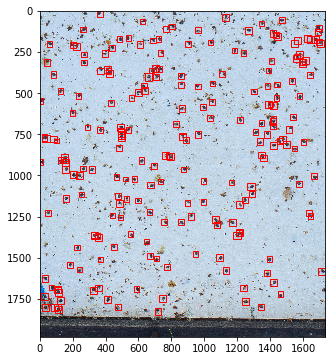

In [22]:
# Image used thoughout the tests to develop our object detector
varroa_01 = skimage.io.imread(os.path.join(test_im_path, '58e7db24579e520d2470641c_32.00px_4.jpg'))
anno_01 = parse_file(os.path.join(test_anno_path, '58e7db24579e520d2470641c_32.00px_4.xml'))

print(varroa_01.shape[0], varroa_01.shape[1])

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(varroa_01)
for anno in anno_01:
    rect = mpatches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
            linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
print(len(anno_01))

In [23]:
def detect_test_1(img):
    
    image_ = rgb2gray(img)
    image_ = image_/255
    d = {} 
    df = pd.DataFrame(d)
          
    (winW, winH) = (50, 50)
    stepsize = 50
    generator = sliding_window(image_, stepSize=stepsize, windowSize=(winW, winH))
    index = 0
    properties_ = []
    for (x, y, image) in generator:
        index += 1
        bin_im = preprocess(image)
        if (bin_im.min() != bin_im.max()):
            # fourier descriptors
            im_label = label(bin_im)
            regionlst = regionprops(im_label)
            areas = [region.area for region in regionlst]
            i = areas.index(max(areas))    
            properties_.append(regionlst[i])
            
            # other descriptors
            descr = get_handy_descriptors(bin_im, back_ground=0)
            #imsave('../project/img_deub/img'+str(index)+'.jpg', bin_im)
            for (area, perimeter, compacity, eigenratio, solidity, elongation) in descr:
                d_handy = {'area': area, 'perimeter': perimeter, 'compacity': compacity, 
                               'eigenratio':eigenratio, 'solidity':solidity,
                               'elongation': elongation, 'id': id}
                df = df.append(d_handy, ignore_index=True)
        else: continue
    return df, properties_

In [24]:
df, proplst = detect_test_1(varroa_01)
# Sanity check
print(len(df))

fourierlst = get_fourier_descriptors(proplst)

347


Now we extract the same features from the ground truth annotations by extracting the corresponding image window. 

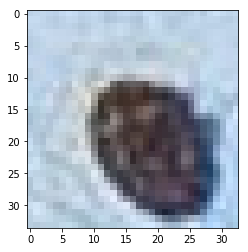

In [25]:
gt_imagelst_01 = [varroa_01[anno['bbox'][1]:anno['bbox'][1] + anno['bbox'][3], anno['bbox'][0]:anno['bbox'][0] + anno['bbox'][2], :] for anno in anno_01]
plt.imshow(gt_imagelst_01[47])

In [26]:
gt_descriptors_01=[]
gt_regionproplst_01=[]
for image in gt_imagelst_01:
    # binarize image
    col_img=image[:,:,0]
    thres = threshold_otsu(col_img)
    bin_img = col_img < thres
    bin_img = binary_opening(bin_img)
    regionproplst = regionprops(label(bin_img))
    desc = get_handy_descriptors(bin_img, back_ground=0)
    maxarea = 0
    k = 0
    if len(desc) > 1:
        for i in range(len(desc)):
            if desc[i][0] > maxarea:
                maxarea = desc[i][0]
                k = i
    gt_regionproplst_01.append(regionproplst[k])
    gt_descriptors_01.append(desc[k])

# create a data frame with the descriptors
gt_d = {} 
gt_df = pd.DataFrame(gt_d)
for (area, perimeter, compacity, eigenratio, solidity, elongation) in gt_descriptors_01:
    d_handy = {'area': area, 'perimeter': perimeter, 'compacity': compacity, 
                    'eigenratio':eigenratio, 'solidity':solidity,'elongation': elongation, 'id': id}
    gt_df = gt_df.append(d_handy, ignore_index=True)

In [27]:
gt_fourierlst = get_fourier_descriptors(gt_regionproplst_01)
#Sanity check
print(len(gt_fourierlst))

217


Fourier descriptors of the objects detected - 0: test objects 1: ground truth varroas


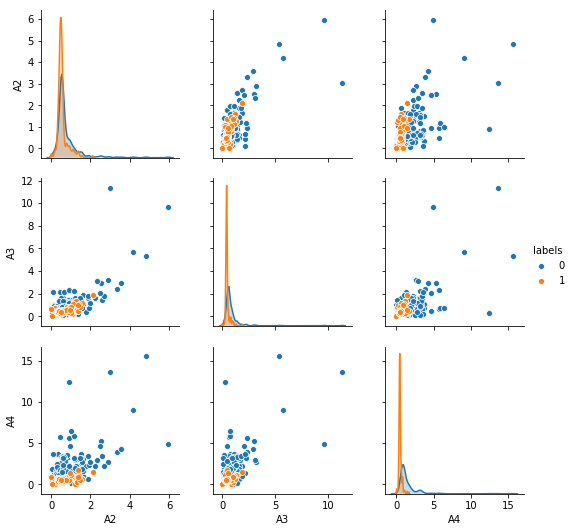

In [28]:
# Plotting the features extracted with the simple segmentation and the ground truth features
# Now we must find the good Fourier coefficients as features to separate the different objects

df_fourier = pd.DataFrame(fourierlst)
df_fourier.columns = ['A2', 'A3','A4']
gt_df_fourier = pd.DataFrame(gt_fourierlst)
gt_df_fourier.columns = ['A2', 'A3','A4']

# labels
labels_varroas = pd.DataFrame(np.zeros([len(df_fourier),1])).astype('int32')

frames_varr = [df_fourier, labels_varroas]
varr_features = pd.concat(frames_varr, axis=1)
varr_features.columns = ['A2', 'A3','A4', 'labels']

labels_gt = pd.DataFrame(np.ones([len(gt_df_fourier) ,1])).astype('int32')

frames_gt = [gt_df_fourier, labels_gt]
gt_features =  pd.concat(frames_gt, axis=1)
gt_features.columns = ['A2', 'A3','A4', 'labels']

frames = [varr_features, gt_features]
features_ = pd.concat(frames, axis=0, ignore_index=True)

features_.columns = ['A2', 'A3','A4', 'labels']
features_.reset_index()
features_.head()

s = sns.pairplot(features_, vars= ['A2', 'A3','A4'], hue='labels')
print("Fourier descriptors of the objects detected - 0: test objects 1: ground truth varroas")

We can easily see that the fourier descriptors do not seem to very well discriminate between the varroas and the rest o fthe detected objects in the image, indeed, the values of the Fourier descriptors are way too close to be relevant. We would like a better distribution of the features in the feature space, so that we will try to use other features hand-chosen before:

In [29]:
df.drop('id', axis=1, inplace=True)
gt_df.drop('id', axis=1, inplace=True)

In [30]:
df.head(3)

,area,compacity,eigenratio,elongation,perimeter,solidity
0,359.0,20.293966,3.015940,1.736646,85.355339,0.871359
1,353.0,27.444072,2.986635,1.728188,98.426407,0.769063
2,349.0,33.965665,4.132048,2.032744,108.876154,0.730126


In [31]:
gt_df.head(3)

,area,compacity,eigenratio,elongation,perimeter,solidity
0,320.0,16.815643,1.657334,1.287375,73.355339,0.963855
1,330.0,17.318347,1.815690,1.347475,75.597980,0.962099
2,442.0,19.041287,1.763203,1.327856,91.740115,0.936441


Hand-chosen descriptors of the objects detected - 0: test objects 1: ground truth varroas


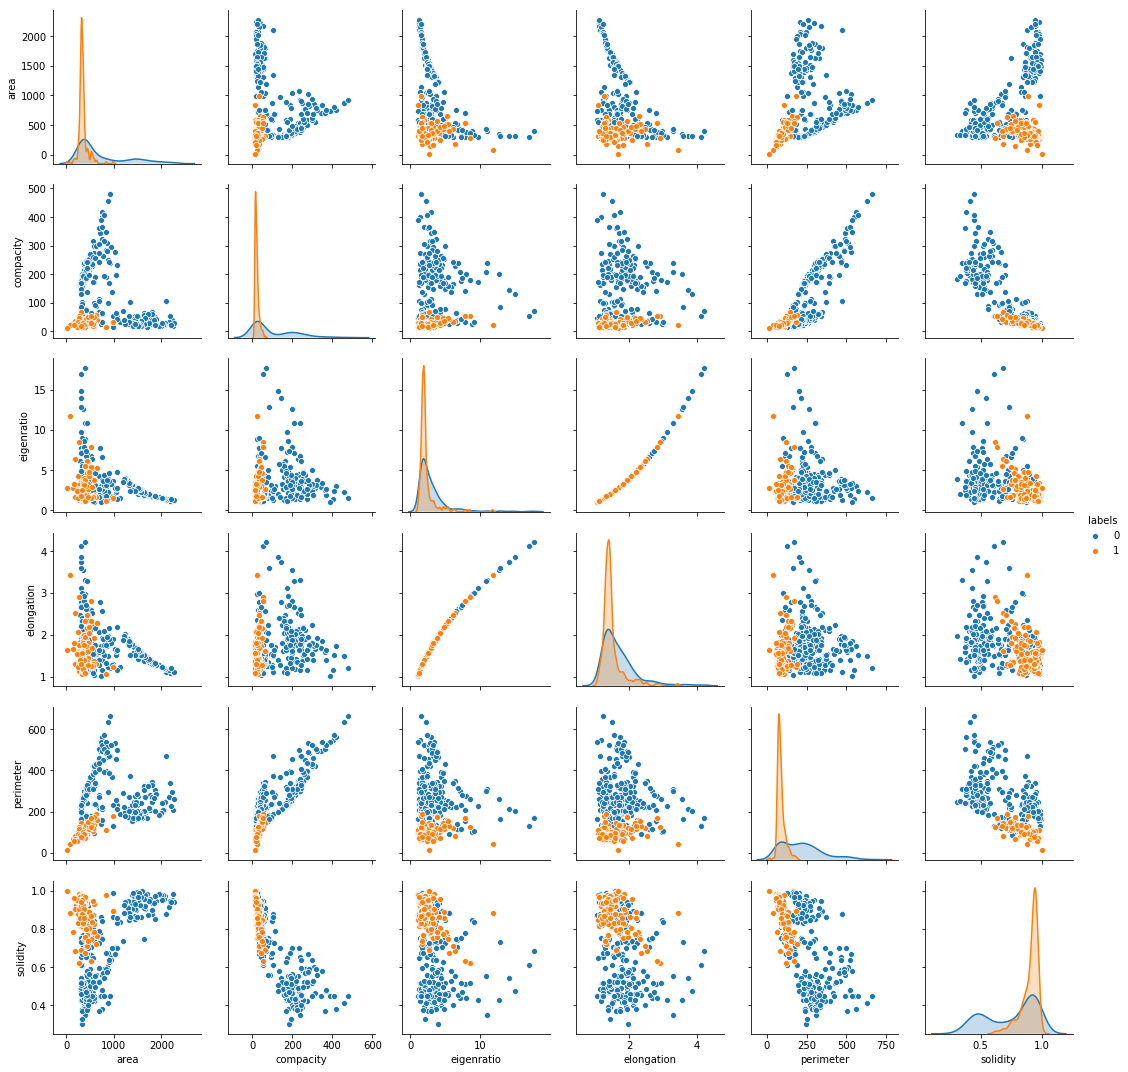

In [32]:
# Plotting the features extracted with the simple segmentation and the ground truth features
# Now we must find the good image features to separate the different objects

# labels
labels_varroas = pd.DataFrame(np.zeros([len(df),1])).astype('int32')

frames_varr = [df, labels_varroas]
varr_features = pd.concat(frames_varr, axis=1)
varr_features.columns = ['area', 'compacity','eigenratio', 'elongation', 'perimeter', 'solidity', 'labels']

labels_gt = pd.DataFrame(np.ones([len(gt_df) ,1])).astype('int32')

frames_gt = [gt_df, labels_gt]
gt_features =  pd.concat(frames_gt, axis=1)
gt_features.columns = ['area', 'compacity','eigenratio', 'elongation', 'perimeter', 'solidity', 'labels']

frames = [varr_features, gt_features]
features_ = pd.concat(frames, axis=0, ignore_index=True)

features_.columns = ['area', 'compacity','eigenratio', 'elongation', 'perimeter', 'solidity', 'labels']
features_.reset_index()
features_.head()

s = sns.pairplot(features_, vars= ['area', 'compacity','eigenratio', 'elongation', 'perimeter', 'solidity'], hue='labels')
print("Hand-chosen descriptors of the objects detected - 0: test objects 1: ground truth varroas")

First of all we can already see with these features that the features points occupy way better the feature space and are more distributed than with the Fourier descriptors.

From the plotted features, we could see that the ones that seem to best separate the ground truth varroas from the rest of the objects detected on the an image are the solidity and elongation. The area and perimeter are dependent from the scaling of the image, so that we should not use these on the collection of images of varroas, which are scaled differently. 

The features we selected were the elongation and solidity.

In [33]:
def get_features(x, y, binary_image, x_shape, y_shape):
    '''
        Compute the descriptors for a binary_image.
        Input:  x, y coordinates of the window
                Binary image
        Output: [x, y, width, height] annotation of the object in the image
                [solidity, elongation] featues of the object
    '''
    annotation = []
    
    im_label = label(image)
    im_props = regionprops(im_label, coordinates = 'rc')
    areas = [region.area for region in im_props]
    i = areas.index(max(areas)) 
    properties = im_props[i]
    # draw rectangle around segmented varroa
    minr, minc, null, maxr, maxc, null = properties.bbox # returns (min_row, min_col, max_row, max_col)
    # required format [x_n, y_n, w_n, h_n]
    annotation = [minc+x, minr+y, maxc-minc, maxr-minr]
    solidity = properties.solidity
    #elongation
    max_diameter = max(properties.minor_axis_length, properties.major_axis_length)
    min_diameter = min(properties.minor_axis_length, properties.major_axis_length)
    small_number = 1e-1
    elongation = max_diameter/min_diameter if(min_diameter != 0) else max_diameter/small_number 

    return annotation, [elongation, solidity]

#### Classification

***One Class SVM***

To do so there are actually several methods already implemented in *scikit-learn* that might be of use, so that we will first try these. The first we will try is the *OneClassSVM*. As actually the goal is to identify varroas, to only one class of object with the features. The features that are not close enough to the training varroas's features, will then be classified as outliers.  

We are actually in the case of a one class classitication (OOC), so that the simplest classfier we could implement, would be one that would look at the features of an object, then define a distance between these features in the feature space and a group of features of known labeled objects. 

We would like to identify the smallest hypersphere (with radius r, and center c) consisting of all the data points. So basically this is a novel/outlier detector.

The one class SVM use here actually uses a Radial Basis Function (RBF) kernel. Compared to the linear kernel that RBF SVM is able to better classes in the feature space that cannnot easily be separated by a linear decision function, but might be with a rather more complex curve and shape. 

But first let's separate the features of the object extracted  with the segmentation and see if they are varroas or not by comparing them the the ground truth images. 

In [34]:
# Make 2 dataframes with the segmented data by comparing the bounding boxes to ground truth ones
def gt_overlap(rect1, rect2):  
    ''' Computes the overlap between annotations detected by our method and ground truth annotations in the xmls files. '''
    dx = min(rect1[0]+rect1[2], rect2['bbox'][0]+rect2['bbox'][2]) - max(rect1[0], rect2['bbox'][0])
    dy = min(rect1[1]+rect1[3], rect2['bbox'][1]+rect2['bbox'][3]) - max(rect1[1], rect2['bbox'][1])
    if (dx>=0) and (dy>=0):
        return dx*dy
    else: return 0

In [35]:
def detect_test_2(img):
    image_ = rgb2gray(img)
    image_ = image_/255

    df = pd.DataFrame({})
          
    (winW, winH) = (50, 50)
    stepsize = 50
    generator = sliding_window(image_, stepSize=stepsize, windowSize=(winW, winH))
    index = 0
    annotations = []
    for (x, y, image) in generator:
        index += 1
        bin_im = preprocess(image)
        if (bin_im.min() != bin_im.max()):
            im_label = label(bin_im)
            regionlst = regionprops(im_label, coordinates = 'rc')
            areas = [region.area for region in regionlst]
            i = areas.index(max(areas)) 
            properties = regionlst[i]
            
            minr, minc, maxr, maxc = properties.bbox 
            annotations.append([minc+x, minr+y, maxc-minc, maxr-minr])
            
            solidity = properties.solidity
            #elongation
            max_diameter = max(properties.minor_axis_length, properties.major_axis_length)
            min_diameter = min(properties.minor_axis_length, properties.major_axis_length)
            small_number = 1e-1
            elongation = max_diameter/min_diameter if(min_diameter != 0) else max_diameter/small_number
            d_handy = {'elongation': elongation, 
            'solidity':solidity}
            df = df.append(d_handy, ignore_index=True)
        else: continue
    return annotations, df

In [36]:
annotations_, df_ = detect_test_2(varroa_01)
labels = np.zeros(len(annotations_))
for anno in anno_01:
    for i, anno1 in enumerate(annotations_) :
        if gt_overlap(anno1, anno) > 0:
            labels[i]=1
        else: continue
df_['labels']=labels

To train and test the different classifiers we used the groundtruth annotations for one image and the annotations found with the previous preprocessing and the feature extraction, so that they contain true positive annotations and false positives. 

We compare the annotations we found with the ground truth ones to find the true positives and make different groups of data for the training and testing of the classifiers. 

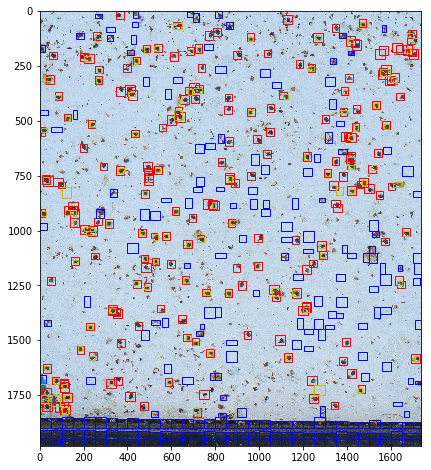

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(varroa_01)
# Ground truth annotations in red
for anno in anno_01:
    rect = mpatches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
            linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
# All the annotations resulting from the segmentation 
for anno, lab in zip(annotations_, labels):
    # False positive annotations
    if lab == 0:
        rect = mpatches.Rectangle((anno[0], anno[1]), anno[2], anno[3],
            linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect)
    # True positive annotations
    else : 
        rect = mpatches.Rectangle((anno[0], anno[1]), anno[2], anno[3],
            linewidth=1,edgecolor='y',facecolor='none')
        ax.add_patch(rect)

In [38]:
# Create meshgrid of the feature space
max_df = df_.max()
min_df = df_.min()

f1_range = np.arange(min_df['elongation'], max_df['elongation'], 0.01) 
f2_range = np.arange(min_df['solidity'], max_df['solidity'], 0.001)

f1_grid, f2_grid = np.meshgrid(f1_range, f2_range)

meshgrid = np.dstack((f1_grid, f2_grid))

# Sanity check
print(meshgrid.shape)

df_meshgrid = pd.DataFrame(np.reshape(meshgrid,(meshgrid.shape[0]*meshgrid.shape[1], meshgrid.shape[2])), columns=['elongation', 'solidity'])

(693, 318, 2)


In [39]:
# fit the model
oclf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
oclf.fit(gt_features[['elongation', 'solidity']])
y_pred_train = oclf.predict(gt_features[['elongation', 'solidity']])
y_pred_test = oclf.predict(df_[['elongation', 'solidity']])

train_acc = accuracy_score(oclf.predict(gt_features[['elongation', 'solidity']]),gt_features['labels'])
print("train acc {}".format(train_acc))
test_acc = accuracy_score(oclf.predict(df_[['elongation', 'solidity']]),df_['labels'])
print("test acc {}".format(test_acc))

train acc 0.9032258064516129
test acc 0.2807017543859649


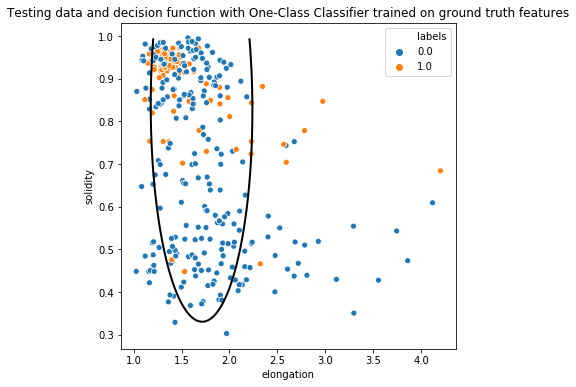

In [40]:
# plot the line, the points, and the nearest vectors to the plane
plt.subplots(figsize=(6,6))
sns.scatterplot(x= 'elongation', y= 'solidity', data = df_[['elongation', 'solidity','labels']], hue="labels", sizes=(10, 7)).set_title('Testing data and decision function with One-Class Classifier trained on ground truth features')

d_func = oclf.decision_function(np.c_[f1_grid.ravel(), f2_grid.ravel()])
d_func = d_func.reshape(f1_grid.shape)
d_cont = plt.contour(f1_grid, f2_grid, d_func, 0, linewidths=2, colors = 'black')

***Classical SVM*** 

On the second time, we decided to buid a simple SVM classfier but this time by defining two classes, one with the  ground truth labels and one with all the stuff in the image that should not be classified as varroas.

Lets separate in the segmeted objects all the annotations that correspond to ground truth ones. 

Here we used a special class of the *svm*, the C-Support Vector Classification

In [41]:
df_false = df_[df_.labels == 0]

frames_gt = [pd.DataFrame(gt_features[['solidity', 'elongation', 'labels']]), df_false]
df_data=  pd.concat(frames_gt, axis = 0, sort = False)

In [42]:
#Classical SVM with 2 classes 
clf = svm.SVC(gamma='auto')

clf.fit(df_data[['elongation', 'solidity']], df_data['labels'])
train_acc = accuracy_score(clf.predict(df_data[['elongation', 'solidity']]), df_data['labels'])
val_acc = accuracy_score(clf.predict(df_[['elongation', 'solidity']]), df_['labels'])

print("train acc {}".format(train_acc))
print("val acc {}".format(val_acc))

train acc 0.7450110864745011
val acc 0.6666666666666666


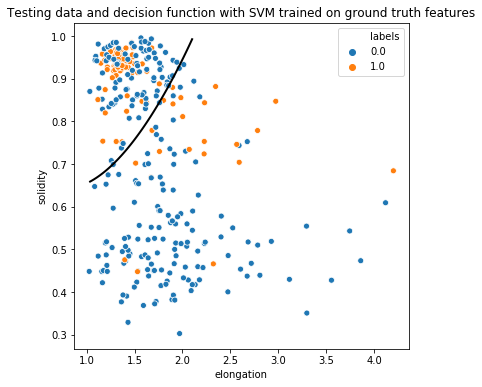

In [43]:
# plot the line, the points, and the nearest vectors to the plane
plt.subplots(figsize=(6,6))
sns.scatterplot(x= 'elongation', y= 'solidity', data = df_[['elongation', 'solidity','labels']], hue="labels", sizes=(10, 7)).set_title('Testing data and decision function with SVM trained on ground truth features')

d_func = clf.decision_function(np.c_[f1_grid.ravel(), f2_grid.ravel()])
d_func = d_func.reshape(f1_grid.shape)

d_cont = plt.contour(f1_grid, f2_grid, d_func, 0, linewidths=2, colors = 'black')

***Bayesian Classifer***

For the Bayesian classfier, we are going to use the corresponding class implemented in *scikit-learn* to make use of the accuracy calcaltion methods implemented in the package to be able to actually compare the different methods of classification available. 

To use the Bayesian classifier we assume the distribution of points in the feature space is known and gaussian. If we look at the density plots above done to compare the different features and select the best one, we can see that this assumption is reasonable as the densities of the features follow a gaussian tendency

In [44]:
gclf = GaussianNB()
gclf.fit(df_data[['elongation', 'solidity']], df_data['labels']) 

y_train = gclf.predict(df_data[['elongation', 'solidity']])
y_test = gclf.predict(df_[['elongation', 'solidity']])

train_acc = gclf.score(df_data[['elongation', 'solidity']], df_data['labels'])
val_acc = gclf.score(df_[['elongation', 'solidity']], df_['labels'])

print("train acc {}".format(train_acc))
print("val acc {}".format(val_acc))

train acc 0.738359201773836
val acc 0.6608187134502924


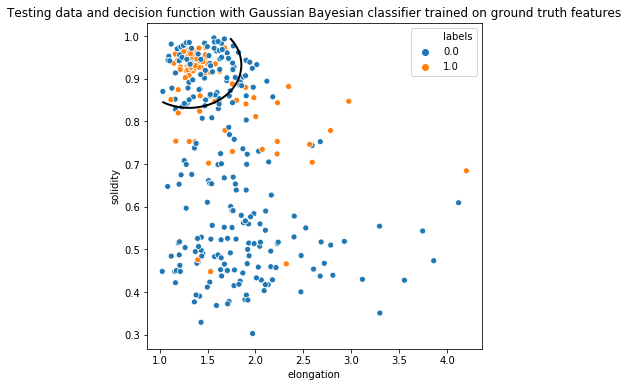

In [45]:
# plot the line, the points, and the nearest vectors to the plane
plt.subplots(figsize=(6,6))
sns.scatterplot(x= 'elongation', y= 'solidity', data = df_[['elongation', 'solidity','labels']], hue="labels", sizes=(10, 7)).set_title('Testing data and decision function with Gaussian Bayesian classifier trained on ground truth features')

d_func = gclf.predict_proba(np.c_[f1_grid.ravel(), f2_grid.ravel()])[:, 1]
d_func = d_func.reshape(f1_grid.shape)

d_cont = plt.contour(f1_grid, f2_grid, d_func, 0, linewidths=2, colors = 'black')

***K-means***

Now that we have 2 classes with the true varroas we could try other types of classifiers in the *scikit-learn* package. A k-means classifier is actually a robuts classifier and can as well as the RBF SVM fit quite nicely the classes in the feature space even if these are not too well distributed. 

In [46]:
from sklearn.cluster import KMeans

kmeans = KMeans(init='k-means++', n_clusters=2, n_init=10)
kmeans.fit(df_data[['elongation', 'solidity']])

train_acc = accuracy_score(kmeans.predict(df_data[['elongation', 'solidity']]), df_data['labels'])
val_acc = accuracy_score(kmeans.predict(df_[['elongation', 'solidity']]), df_['labels'])

print("train acc {}".format(train_acc))
print("val acc {}".format(val_acc))

train acc 0.4035476718403548
val acc 0.52046783625731


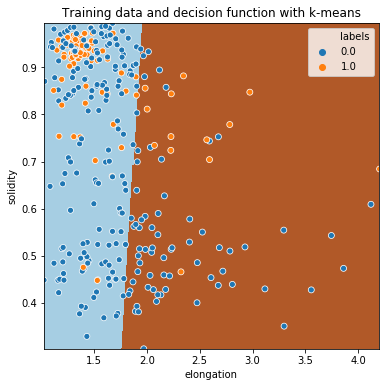

In [47]:
# plot the line, the points, and the nearest vectors to the plane
plt.subplots(figsize=(6,6))
sns.scatterplot(x= 'elongation', y= 'solidity', data = df_[['solidity', 'elongation', 'labels']], hue="labels", sizes=(10, 7)).set_title('Training data and decision function with k-means')

Z = kmeans.predict(np.c_[f1_grid.ravel(), f2_grid.ravel()])
Z = Z.reshape(f1_grid.shape)

plt.imshow(Z, interpolation='nearest',extent=(f1_grid.min(), f1_grid.max(), f2_grid.min(), f2_grid.max()),cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

With the k-means, we can see that the training accuracy is not 1, unlike the classification that uses the SVM or the Naive Bayesian classifer. Also the presicted classes do not seem to fit the data at all. 

***Conclusion***

The One Class SVM does not seem to yield good accuracies and therfore a good classfication of the features, so that we will not use this one for feature classification.

The k-means classifier is too dependent on the random initialization of the set of means, giving out different decision boundaries and therefore accuracies after several runs and therefore is not stable enough to be applied to all the images. 

The Bayesian classifier and the SVM  with RBF kernel seemed to produce similar results and were the best ones to classify our data. Theroretically the SVM classifier could the class clusters better if these have intricate shapes and distributions, so that this is the one that will be preferred for feature classification. Also as SVM had slightly better accuracies, we will use this one. 

In [48]:
def classify_features(features =[elongation, solidity]): 
    '''
        Classifies the features as part of the varroa class or not using an RBF SVM already trained. 
        Input: Features as a list of two objects, [solidity, elongation] decribing the object 
        Output: bool, True if the object is a varroas, False if not 
    '''
    cls = clf.predict([[elongation, solidity]])
    if cls == 1: 
        return True
    else : return False

#### Full object detection by sliding window

Now that we have selected the relevant features and found a classifier to find the classes of our data, we should be able find varroas in the sliding windows. 

In [49]:
def detect_by_method_1(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''
    image_ = rgb2gray(img)
    image_ = image_/255
    df = pd.DataFrame({})
          
    (winW, winH) = (70, 70)
    stepsize = 70
    generator = sliding_window(image_, stepSize=stepsize, windowSize=(winW, winH))
    
    annotations = []
    for (x, y, image) in generator:
        bin_im = preprocess(image)
        if type(bin_im) != type(None):
            if (bin_im.min() != bin_im.max()):
                anno, feat = get_features(x, y, bin_im, img.shape[1], img.shape[0])
                if classify_features(feat):
                    annotations.append(anno)
        else : 
            continue
    return annotations

In [50]:
all_annotations = []
for im, nm in zip(ic, im_names):
    anno = detect_by_method_1(im)
    all_annotations.append(anno)
    file = open(nm+'.txt',"w") 
    file.write(str(anno))
    file.close()

#### Precision, Recall and F1-score

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [51]:
img_IoUs = []
zero_inter = []
for index, (test_annotations, gth_annotations) in enumerate(zip(all_annotations,annotations_xmls)):
    imIoU = []
    for t_anno in test_annotations:
        inter_iou = []
        for g_anno in gth_annotations:
            overlap_a = gt_overlap(t_anno,g_anno)
            # if(overlap_a != 0): print(overlap_a); print("***********")
            grd_t_a = g_anno['bbox'][2]*g_anno['bbox'][3]
            f_box_a = (t_anno[2])*(t_anno[3])
            inter_iou.append(overlap_a/(grd_t_a+f_box_a-overlap_a))
            
        if inter_iou:
            imIoU.append(max(inter_iou))
        else : zero_inter.append(index)
    img_IoUs.append(imIoU)

In [52]:
def Precision_Recall_F1(img_IoUs, annotations_xmls, T=0.3):
    '''Computes the required score for a given T value '''
    Precisions = []
    Recalls = []
    F1_scores =[]
    
    for IoUs, annotations in zip(img_IoUs, annotations_xmls):
        truePositives = []
        for IoU in IoUs:
            # define a threshold T to consider a label as a true positive when compared to the set of ground truth labels
            if IoU >= T:
                truePositives.append(IoU)
        # number of true positives are the ones with a IoU higher than a certain value T.
        tp = len(truePositives)
        # number of false negatives = number of ground truth bbox labels - the number of true positives
        fn = len(annotations) - tp
        # number of false positives = number of labels found by our algorithm - the number of true positives
        fp  =  len(IoUs)  - tp
        if tp >0 and fp>0:
            precision = tp/(tp+fp)
        else : precision = 0
        if tp >0 and fn > 0:
            recall = tp/(tp+fn)
        else : recall = 0
        if precision > 0 and recall > 0:
            F1 = 2*precision*recall/(precision+recall)
        else : F1 = 0
        Precisions.append(precision)
        Recalls.append(recall)
        F1_scores.append(F1)

    return (Precisions,Recalls,F1_scores)

In [53]:
#Threshold = 0.3
Precisions_03,Recalls_03,F1_scores_03 =Precision_Recall_F1(img_IoUs,annotations_xmls)

print("For a T value of 0.3:")
print("")
for precision,recall,score,im in zip(Precisions_03,Recalls_03,F1_scores_03, im_names):
    print("   Image %s: Precision: %g, Recall:  %r, F1_score: %s." % (im, precision,recall,score))
print("")

For a T value of 0.3:

   Image 58e7c5e3579e52085efb48f4_32.00px_2: Precision: 0, Recall:  0, F1_score: 0.
   Image 58e7db24579e520d2470641c_32.00px_4: Precision: 0, Recall:  0, F1_score: 0.
   Image 58ea4f69579e520dd055b3db_32.00px_6: Precision: 0, Recall:  0, F1_score: 0.
   Image 59023fbd579e52581ddede9f_32.00px_20: Precision: 0, Recall:  0, F1_score: 0.
   Image 5903312b579e52581ddedea8_32.00px_11: Precision: 0, Recall:  0, F1_score: 0.
   Image 5903312b579e52581ddedea8_32.00px_4: Precision: 0, Recall:  0, F1_score: 0.
   Image 59855d29579e529fdea8af13_32.00px_10: Precision: 0, Recall:  0, F1_score: 0.
   Image 59919820579e52a0e6c05e46_32.00px_2: Precision: 0, Recall:  0, F1_score: 0.
   Image 5991982d579e52a0e6c05e47_32.00px_4: Precision: 0, Recall:  0, F1_score: 0.
   Image 599a969f579e52a0e6c05e4f_32.00px_1: Precision: 0, Recall:  0, F1_score: 0.
   Image 599a969f579e52a0e6c05e4f_32.00px_3: Precision: 0, Recall:  0, F1_score: 0.
   Image 599a9c3e579e52a0e6c05e51_32.00px_4: Preci

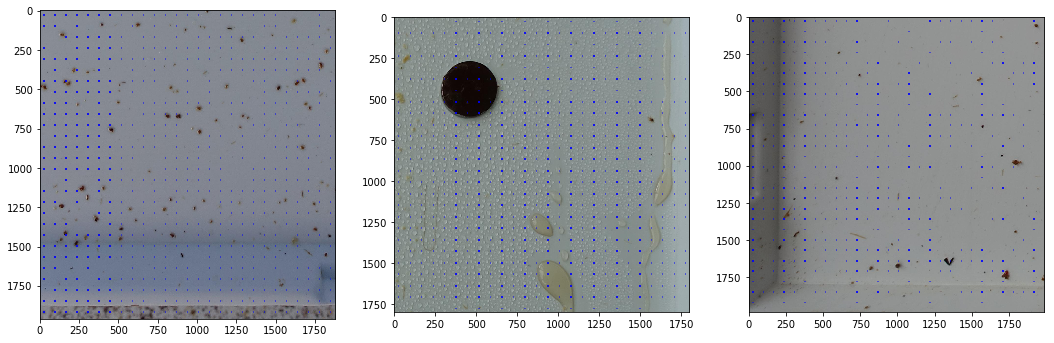

In [56]:
filenames = ['5bf9855da07d568353ddcf22_32.00px_18', '5a04a2ada07d56baef59b1aa_32.00px_3', '5a19d440a07d5643ecfab27c_32.00px_8']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, file in zip(axes.ravel(), filenames):
    index = im_names.index(file)
    img =  ic[index]
    ax.imshow(img)
    for anno in all_annotations[index]:
        rect = mpatches.Rectangle((anno[0], anno[1]), anno[2], anno[3],
            linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect)

***Conclusion***

The resulting precision and recall values are all zero and the IoUs are also way too small, to correct that we briefly tried to train the SVM classifier with more data but this resulted in an SVM unable to converge, so that maybe the choice of features was not the wisest. We also made some trials with the compacity given to the classifiers, but the same problem was met. 

Also when plotting the annotations, we could see that these were not placed at all near the varroas but rather at very regular spacings, probably corresponding to the sliding of the windows. This was probably due to the feature extraction as randomly during our trials, the *regionprops* function of skimage started to return 6 values for the bounding box instead of 4. 
We tried solved that by setting 2 of these values to null (the smallest ones, corresponding to 2 pixels, so obviously not to either the x or y coordinates of the bounding box. 
However this problem solving may not have been enough and an underlying malfunction of *skimage* could be in cause. As you can see all the methods previously used were working quite well and this problem only started when trying to compute the object detection on the whole image dataset. 

In the future, we should find a way to solve these problems and maybe add some optimization functions to the detectors. As we don't know where are the objects to detect, we should choose smaller stepSizes to shift the window and therefore because this will cause a lot of bounding boxes to overlap, implement a Non-maxima suppression function to merge the overlaping annotations.